In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [7]:
# Category "name" spectrogram example
# Categories include Noise, SinglePerson, SingleRunning, DogWalking
name = "Noise"
ynoise, sr = librosa.load('dataset/' + name + '1.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

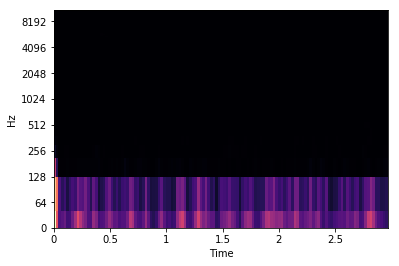

In [105]:
librosa.display.specshow(ps, y_axis='log', x_axis='time')

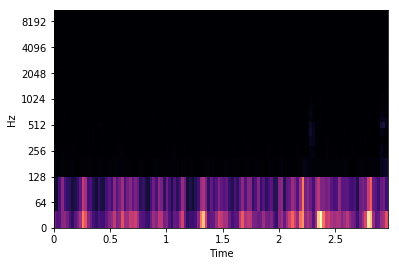

In [9]:
# Category "name" spectrogram example
# Categories include Noise, SinglePerson, SingleRunning, DogWalking
name = "SinglePerson"
yperson, sr = librosa.load('dataset/' + name + '1.wav', duration = 2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape
librosa.display.specshow(ps, y_axis='log', x_axis='time')

In [10]:
yperson.shape

(65489,)

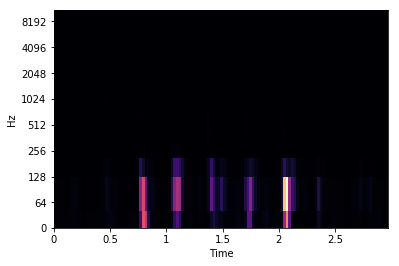

In [107]:
# Category "name" spectrogram example
# Categories include Noise, SinglePerson, SingleRunning, DogWalking
name = "SingleRunning"
y, sr = librosa.load('dataset/' + name + '1.wav', duration = 2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape
librosa.display.specshow(ps, y_axis='log', x_axis='time')

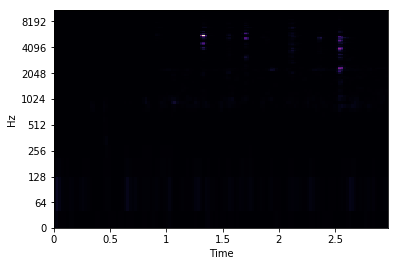

In [18]:
# Category "name" spectrogram example
# Categories include Noise, SinglePerson, SingleRunning, DogWalking
name = "DogWalking"
y, sr = librosa.load('dataset/' + name + '1.wav', duration = 2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape
librosa.display.specshow(ps, y_axis='log', x_axis='time')

In [88]:
# add augmented and non-augmented class data to the main dataset
def add_category(name, speed_mod, pitch_mod, data, cat_num):
    # Initialize dataset by appending class "name" samples.
    # 1,2,3,4 exists
    for i in range(1,5):
        y, sr = librosa.load('dataset/' + name + str(i) + '.wav', duration = 2.97)
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128,128): continue
        if ps.shape == (128,128):
            data.append((ps,cat_num))

    # append additional class "name" data with different speeds. Amount added per speed_mod: 8
    for r in range(0,speed_mod):
       for i in range(1,5):
            y, sr = librosa.load('dataset/' + name +  str(i) + '.wav', duration = 2.97)
            y_slow = librosa.effects.time_stretch(y, rate= 0.84 + 0.01*r)
            y_fast = librosa.effects.time_stretch(y, rate = 0.94 + 0.01*r)
            librosa.output.write_wav('augmented/' + name +  str(i) + 'slow.wav', y_slow, sr)
            librosa.output.write_wav('augmented/' + name +  str(i) + 'fast.wav', y_fast, sr)

            y, sr = librosa.load('augmented/' + name +  str(i) + 'slow.wav', duration = 2.97)
            ps = librosa.feature.melspectrogram(y=y, sr=sr)

            if ps.shape == (128,128):
                data.append((ps,cat_num))

            y, sr = librosa.load('augmented/' + name + str(i) + 'fast.wav', duration = 2.97)
            ps = librosa.feature.melspectrogram(y=y, sr=sr)

            if ps.shape == (128,128):
                data.append((ps,cat_num))
    # append additional class "name" data with different pitch. Amount added per pitch_mod: 8
    for n in range(0,pitch_mod):
        for i in range(1,5):
            y, sr = librosa.load('dataset/' + name + str(i) + '.wav', duration = 2.97)
            y_low = librosa.effects.pitch_shift(y, sr, n_steps = -2 + 0.05*n)
            y_high = librosa.effects.pitch_shift(y, sr, n_steps = 2 + 0.05*n)
            librosa.output.write_wav('augmented/' + name + str(i) + 'low.wav', y_low, sr)
            librosa.output.write_wav('augmented/' + name + str(i) + 'high.wav', y_high, sr)

            y, sr = librosa.load('augmented/' + name + str(i) + 'low.wav', duration = 2.97)
            ps = librosa.feature.melspectrogram(y=y, sr=sr)

            if ps.shape == (128,128):
                data.append((ps,cat_num))

            y, sr = librosa.load('augmented/' + name + str(i) + 'high.wav', duration = 2.97)
            ps = librosa.feature.melspectrogram(y=y, sr=sr)

            if ps.shape == (128,128):
                data.append((ps,cat_num))

    return len(data)



In [75]:
def cnn_train_and_test(data, size, num_categories, val_acc_list, val_loss_list, num_epochs):
    shuffled_data = data
    total = len(data)
    random.shuffle(shuffled_data)
    train_set = shuffled_data[:math.floor(size - size/10)]
    test_set = shuffled_data[math.floor(size - size/10):]

    train_x, train_y = zip(*train_set)
    test_x, test_y = zip(*test_set)

    # Create CNN input and Class Sets for Train and Test
    train_x = np.array([x.reshape( (128,128,1) ) for x in train_x])
    train_y = np.array(keras.utils.to_categorical(train_y,num_categories))

    test_x = np.array([x.reshape( (128,128,1) ) for x in test_x])
    test_y = np.array(keras.utils.to_categorical(test_y,num_categories))

    model = Sequential()
    input_shape = (128,128,1)

    model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
    model.add(MaxPooling2D((4, 2), strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5, 5), padding="valid"))
    model.add(MaxPooling2D((4, 2), strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5, 5), padding="valid"))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(rate=0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_categories))
    model.add(Activation('softmax'))
    for i in range(0, num_epochs):
        model.compile(
            optimizer="Adam",
            loss="categorical_crossentropy",
            metrics=['accuracy'])

        model.fit(
            x=train_x, 
            y=train_y,
            epochs=1,
            batch_size=math.ceil((size - size/10)/8),
            validation_data= (test_x, test_y))

        score = model.evaluate(
            x=test_x,
            y=test_y)

        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('Epoch #', i)
        val_loss_list[i].append(score[0])
        val_acc_list[i].append(score[1])


In [76]:
def get_data(data, speed_mod, pitch_mod):

    add_category("Noise",speed_mod, pitch_mod, data, 0)
    add_category("SinglePerson", speed_mod, pitch_mod, data, 1)
    add_category("SingleRunning", speed_mod, pitch_mod, data, 2)
    add_category("DogWalking", speed_mod, pitch_mod, data, 3)
    return len(data)

In [87]:
def get_average_scores(data, size, runs, num_epochs, accuracies, losses, nth_dataset):
    val_loss_list = []
    val_acc_list = []
    for i in range(0, num_epochs):
        val_loss_list.append([])
        val_acc_list.append([])
    for i in range(0, runs):
        print("Run: ", i)
        cnn_train_and_test(data, size, 4, val_acc_list, val_loss_list, num_epochs)
    for i in range(0, num_epochs):
        accuracies[nth_dataset].append(round(sum(val_acc_list[i])/float(len(val_acc_list[i])),2))
        losses[nth_dataset].append(round(sum(val_loss_list[i])/float(len(val_loss_list[i])),2))

In [89]:
def get_accs_and_losses(epochs, data_samples, runs, num_epochs, accuracies, losses):
    for i in range(0, len(data_samples)):
        accuracies.append([])
        losses.append([])
    for i in range(0, len(data_samples)):
        data = []
        speed_mod = i
        pitch_mod = 0
        size = get_data(data, speed_mod, pitch_mod)
        print("Number of Samples: ", size)
        get_average_scores(data, size, runs, num_epochs, accuracies, losses, i)
        
    

In [85]:
def get_heat_map(accuracies):
    true_accuracies = np.array(accuracies)
    fig, ax = plt.subplots()
    im = ax.imshow(true_accuracies)
    
    ax.set_xticks(np.arange(len(data_samples)))
    ax.set_yticks(np.arange(len(epochs)))
    
    ax.set_xticklabels(data_samples)
    ax.set_yticklabels(epochs)
    
    plt.setp(ax.get_xticklabels(), rotation = 45, ha="right", rotation_mode = "anchor")
    
    for i in range(len(epochs)):
        for j in range(len(data_samples)):
            text = ax.text(j,i, true_accuracies[i, j], ha="center", va="center", color="w")
    ax.set_title("4 Categories CNN Accuracies")
    fig.tight_layout()
    plt.show()

In [80]:
epochs = ["1","2","3"]
data_samples = ["16","48","80"]
accuracies = []
losses = []
get_accs_and_losses(epochs, data_samples, 3, 3, accuracies, losses)

Number of samples:  4
Number of samples:  8
Number of samples:  12
Number of samples:  16
16
Run:  0
Train on 14 samples, validate on 2 samples
Epoch 1/1
2/2 [==============================] - 0s 40ms/step
Test loss: 3.227971076965332
Test accuracy: 0.0
Epoch # 0
Train on 14 samples, validate on 2 samples
Epoch 1/1
2/2 [==============================] - 0s 40ms/step
Test loss: 3.416015863418579
Test accuracy: 0.0
Epoch # 1
Train on 14 samples, validate on 2 samples
Epoch 1/1
2/2 [==============================] - 0s 37ms/step
Test loss: 5.113467216491699
Test accuracy: 0.0
Epoch # 2
Run:  1
Train on 14 samples, validate on 2 samples
Epoch 1/1
2/2 [==============================] - 0s 43ms/step
Test loss: 1.3769938945770264
Test accuracy: 0.5
Epoch # 0
Train on 14 samples, validate on 2 samples
Epoch 1/1
2/2 [==============================] - 0s 41ms/step
Test loss: 1.3789547681808472
Test accuracy: 0.5
Epoch # 1
Train on 14 samples, validate on 2 samples
Epoch 1/1
2/2 [================

In [81]:
for i in range(0, len(accuracies)):
    print("Data Set #: ", i)
    for j in range(0, len(accuracies[i])):
        print("Epoch #: ", j)
        print(accuracies[i][j])

Data Set #:  0
Epoch #:  0
0.16666666666666666
Epoch #:  1
0.3333333333333333
Epoch #:  2
0.16666666666666666
Data Set #:  1
Epoch #:  0
0.6000000139077505
Epoch #:  1
0.6000000139077505
Epoch #:  2
0.800000011920929
Data Set #:  2
Epoch #:  0
0.625
Epoch #:  1
0.75
Epoch #:  2
0.9583333333333334


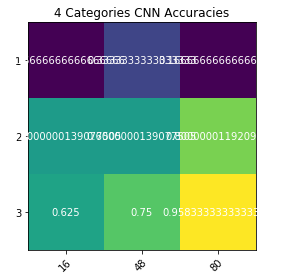

In [86]:
get_heat_map(accuracies)